# Load libraries and set device up

In [28]:
import matplotlib.pyplot as plt
import numpy             as np
import seaborn           as sns
import torch.nn          as nn
import os
import torch
import json

import libraries.model   as clm
import libraries.dataset as cld

from torch_geometric.loader import DataLoader

# Checking if pytorch can run in GPU, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

sns.set_theme()

# Define parameters

In [2]:
n_epochs      = 300
batch_size    = 128
learning_rate = 0.001
dropout       = 0.1
patience      = 10
delta         = 2
train_ratio   = 0.9
test_ratio    = 0.05  # val_ratio = 1 - train_ratio - test_ratio

dpi = 50

target = 'EPA'
folder = 'MP-EPA-deep'

input_folder  = 'models'
target_folder = f'{input_folder}/{folder}'
model_name    = f'{target_folder}/{target}-model.pt'

# Generate or load graph database for training

In [ ]:
files_names = {
    'dataset_name': f'{target_folder}/dataset.pt',
    'labels_name': f'{target_folder}/labels.pt',
    'train_dt_std_name': f'{target_folder}/train_dataset_std.pt',
    'train_lb_std_name': f'{target_folder}/train_labels_std.pt',
    'val_dt_std_name': f'{target_folder}/val_dataset_std.pt',
    'val_lb_std_name': f'{target_folder}/val_labels_std.pt',
    'test_dt_std_name': f'{target_folder}/test_dataset_std.pt',
    'test_lb_std_name': f'{target_folder}/test_labels_std.pt',
    'std_param_name': f'{target_folder}/standardized_parameters.json',
    'dt_param_name': f'{target_folder}/dataset_parameters.json'
}

In [3]:
# Try loading the training datasets directly, else generate them
try:
    train_dataset, train_labels, val_dataset, val_labels, test_dataset, test_labels, standardized_parameters = cld.load_datasets(files_names)

except FileNotFoundError:
    if not all(os.path.exists(path) for path in [files_names['dataset_name'], files_names['labels_name']]):
        # Generate data
        cld.generate_dataset('datasets/Loaded_PhaseTransition',
                             targets=['EPA', 'bandgap'],
                             data_folder=target_folder)

    # Load the raw dataset, with corresponding labels, and standardize it
    dataset = torch.load(files_names['dataset_name'])
    labels  = torch.load(files_names['labels_name'])

    # Load dataset parameters
    dataset_parameters = cld.load_json(files_names['dt_param_name'])

    # Determine the index for the desired property
    target_idx = [idx for idx, t in enumerate(dataset_parameters['target']) if t == target][0]

    # Select the target we want
    for data in dataset:
        data.y = data.y[target_idx]

    # Split datasets
    train_dataset, train_labels, val_dataset, val_labels, test_dataset, test_labels = cld.split_dataset(train_ratio, test_ratio, dataset, labels)
    del dataset  # Free up CUDA memory

    # Standardize train dataset
    dataset, labels, standardized_parameters = cld.standardize_dataset(train_dataset, train_labels)

    # Select corresponding parameters
    #standardized_parameters['target_mean'] = standardized_parameters['target_mean'][target_idx]
    #standardized_parameters['target_std']  = standardized_parameters['target_std'][target_idx]

    # Standardize test and validation datasets with train parameters
    val_dataset  = cld.standardize_dataset_from_keys(val_dataset,  standardized_parameters)
    test_dataset = cld.standardize_dataset_from_keys(test_dataset, standardized_parameters)

    # Save datasets
    cld.save_datasets(train_dataset, train_labels, val_dataset, val_labels, test_dataset, test_labels, files_names)

    # Save standardized parameters
    cld.save_std_parameters(standardized_parameters, files_names['std_param_name'])

    # Defining target factor
    target_factor = standardized_parameters['target_std'] / standardized_parameters['scale']

/tmp/ipykernel_652427/1108331434.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dataset = torch.load(dataset_name)
/tmp/ipykernel_652427/1108331434.py:33: FutureWarnin

Define data loaders.

In [5]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False, pin_memory=True)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False, pin_memory=True)

# Determine number of node-level features in dataset, considering the t_step information
n_node_features = train_dataset[0].num_node_features

del train_dataset, val_dataset, test_dataset  # Free up CUDA memory

# Generate Graph Neural Network model

In [6]:
model = clm.GCNN(features_channels=n_node_features,
                 pdropout=dropout)

# Moving model to device
model = model.to(device)

if os.path.exists(f'{target_folder}/{target}-model.pt'):
    model.load_state_dict(torch.load(f'{target_folder}/{target}-model.pt'))
    model.train()

# Allow data parallelization among multi-GPU
model= nn.DataParallel(model)
model

DataParallel(
  (module): GCNN(
    (conv1): GraphConv(4, 32)
    (conv2): GraphConv(32, 32)
    (linconv1): Linear(in_features=32, out_features=32, bias=True)
    (linconv2): Linear(in_features=32, out_features=16, bias=True)
    (lin): Linear(in_features=16, out_features=1, bias=True)
  )
)

# Train

Define training optimized and criterion 

In [7]:
# MSELoss is by default defined as the mean within the batch
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = torch.nn.MSELoss()

# Initialize early stopping
early_stopping = clm.EarlyStopping(patience=patience, delta=delta, model_name=model_name)

In [ ]:
# Train the model
train_losses = []
val_losses   = []
for epoch in np.arange(0, n_epochs):
    train_loss, train_predictions, train_ground_truths = clm.train(model, criterion, train_loader,
                                                                   target_factor.to(device),
                                                                   standardized_parameters['target_mean'].to(device),
                                                                   optimizer)
    val_loss,   val_predictions,   val_ground_truths   =  clm.test(model, criterion, val_loader,
                                                                   target_factor.to(device),
                                                                   standardized_parameters['target_mean'].to(device))

    # Pass to energy units (same as initial Fv)
    train_loss = np.sqrt(train_loss) * target_factor.item()
    val_loss   = np.sqrt(val_loss)   * target_factor.item()

    if epoch%5 == 0:
        stack = np.concatenate([train_predictions, train_ground_truths,
                                val_predictions,   val_ground_truths])
    
        _min_ = np.min(stack)
        _max_ = np.max(stack)
    
        plt.figure(figsize=(3, 3))
        plt.plot(train_ground_truths, train_predictions, '.', label='Train')
        plt.plot(val_ground_truths,   val_predictions,   '.', label='Validation')
        plt.xlabel(r'Computed')
        plt.ylabel(r'Predicted ')
        plt.plot([_min_, _max_], [_min_, _max_], '-r')
        plt.legend(loc='best')
        plt.show()
    
    # Append losses
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    # Check early stopping criteria
    early_stopping(val_loss, model)

    if early_stopping.early_stop:
        print('Early stopping')
        break

    print(f'Epoch: {epoch+1}, Train MAE: {train_loss:.4f}, Val MAE: {val_loss:.4f}')

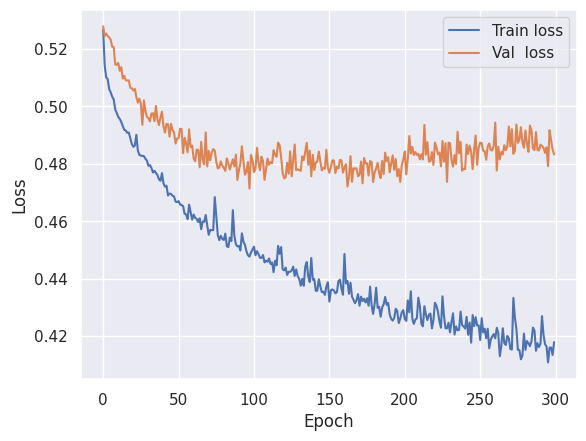

In [9]:
plt.plot(np.log10(train_losses), label='Train loss')
plt.plot(np.log10(val_losses) , label='Val  loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='best')
plt.show()

# Check test data

In [29]:
# Load Graph Neural Network model
model = clm.GCNN(features_channels=n_node_features, pdropout=dropout)

# Moving model to device
model = model.to(device)

# Load Graph Neural Network model
model.load_state_dict(torch.load(f'{target_folder}/{target}-model.pt', map_location=torch.device(device)))
model.eval()  # Evaluation mode, drops out dropouts

/tmp/ipykernel_652427/3130139249.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'{target_folder}/{target}-model.pt', map_location=torc

GCNN(
  (conv1): GraphConv(4, 32)
  (conv2): GraphConv(32, 32)
  (linconv1): Linear(in_features=32, out_features=32, bias=True)
  (linconv2): Linear(in_features=32, out_features=16, bias=True)
  (lin): Linear(in_features=16, out_features=1, bias=True)
)

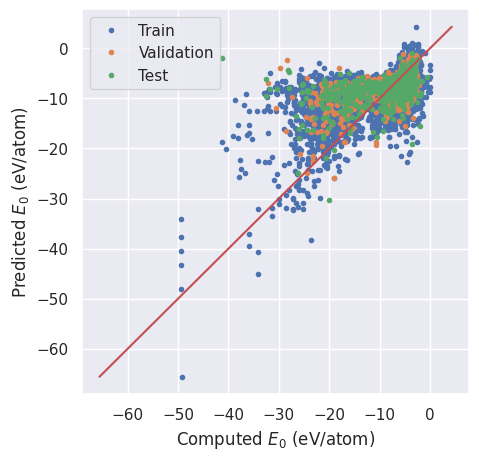

Train MAE: 2.7205, Val MAE: 2.9610, Test MAE: 3.1766


In [30]:
train_loss, train_predictions, train_ground_truths = clm.test(model, criterion, train_loader,
                                                              target_factor.to(device),
                                                              standardized_parameters['target_mean'].to(device))
val_loss,   val_predictions,   val_ground_truths   =  clm.test(model, criterion, val_loader,
                                                               target_factor.to(device),
                                                               standardized_parameters['target_mean'].to(device))
test_loss,  test_predictions,  test_ground_truths  =  clm.test(model, criterion, test_loader,
                                                               target_factor.to(device),
                                                               standardized_parameters['target_mean'].to(device))

# Pass to energy units (same as initial Fv)
train_loss = np.sqrt(train_loss) * target_factor.item()
val_loss   = np.sqrt(val_loss)   * target_factor.item()
test_loss  = np.sqrt(test_loss)  * target_factor.item()

stack = np.concatenate([train_predictions, train_ground_truths,
                        val_predictions,   val_ground_truths,
                        test_predictions,  test_ground_truths])

_min_ = np.min(stack)
_max_ = np.max(stack)

plt.figure(figsize=(5, 5))
plt.xlabel(r'Computed $E_0$ (eV/atom)')
plt.ylabel(r'Predicted $E_0$ (eV/atom)')
plt.plot(train_ground_truths, train_predictions, '.', label='Train')
plt.plot(val_ground_truths,   val_predictions,   '.', label='Validation')
plt.plot(test_ground_truths,  test_predictions,  '.', label='Test')
plt.plot([_min_, _max_], [_min_, _max_], '-r')
plt.legend(loc='best')
plt.savefig(f'{target_folder}/{target}-GCNN-training.pdf', dpi=dpi, bbox_inches='tight')
plt.show()

print(f'Train MAE: {train_loss:.4f}, Val MAE: {val_loss:.4f}, Test MAE: {test_loss:.4f}')

In [31]:
loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

loss, predictions, ground_truths = clm.test(model, criterion, loader,
                                            target_factor.to(device),
                                            standardized_parameters['target_mean'].to(device))

uncertainties = ground_truths - predictions
uncertainties

array([ 0.552639  , -0.9501562 ,  0.6451616 , ..., -0.8977585 ,
        1.8537464 , -0.91661024], dtype=float32)

In [33]:
# Generate dictionary with uncertainty data
# label: uncertainty = ground-truth - prediction
uncertainty_data = {}
for idx, label in enumerate(train_labels):
    uncertainty_data.update(
        {label: float(uncertainties[idx])}
    )

# Dump the dictionary with numpy arrays to a JSON file
with open(f'{target_folder}/uncertainty_data.json', 'w') as json_file:
    json.dump(uncertainty_data, json_file)  